# Previsão de Produção de Petróleo utilizando Aprendizado de Máquina
Mateus de Araujo Fernandes

## Inicialização

### Conexão ao Drive e Importação de Bibliotecas

In [1]:
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

#import os
#os.listdir()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\bevq\OneDrive - PETROBRAS\Documents\Data_Science_Res\ambiente_virtual_doc\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Definição da Função SMAPE

In [2]:
# Opção mais simples, que não funciona com array

def smape_calc(a, f):
    #return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def mape_calc(a, f):
    return 1/len(a) * np.sum(np.abs(f-a)/np.abs(f))

In [6]:
Dataset_CAR = pd.read_csv(filepath_or_buffer = 'Dataset_CAR_quali.csv', sep = ';', header=[0])
#Dataset_CAR = pd.read_csv(filepath_or_buffer = 'Dataset_CAR.csv', sep = ',', header=[0])
Dataset_CAR['Date'] = pd.to_datetime(Dataset_CAR['Date'])
Dataset_CAR.set_index('Date', inplace=True)

Dataset_CAR_resample = Dataset_CAR.resample("20D").mean()
dataset_lido = Dataset_CAR_resample[['RJS646_Qo_pot', 'RJS646_Qg_pot', 'RJS646_Qw_pot', 'RJS687_Qgi_movavg', 'RJS687_Qwi_movavg']]


def gera_dataset (dataset_lido_f, look_back_f, look_forward_f):
    #Função para ler gerar dataset para algoritmo de aprendizado
    array_df=[]
    df=[]
    #Rotina para criação de datasets para Rede MLP
    seq_1, seq_2 = [], []
    for i in range(len(dataset_lido_f)):
      # definição dos limites da janela
	    end_ix = i + look_back_f
	    out_end_ix = end_ix + look_forward_f
	    # interrompe no tamanho do histórico
	    if out_end_ix > len(dataset_lido_f):
		    break
      # agrega dos dados para formar o conjunto de entradas e saídas
	    for j in range(i, end_ix):
		    seq_1.extend(dataset_lido_f.values[j,:])
	    for k in range(end_ix, out_end_ix):
		    seq_1.extend(dataset_lido_f.values[k,0:3])
	    seq_2.append(seq_1)
	    seq_1 = []
    array_df.append(seq_2)

    df = pd.DataFrame(array_df[0])

    return df


### Grid Search

In [84]:
len(data)

190

In [86]:
look_back = [5, 10, 20, 30]
look_forward = 1
amostragem = 20 #[5, 10, 15, 20, 25, 30]
estimator = ["nn", "lr", "rr"]
nn_hidden_layer = [5]#, 10, 15, 20, 40, 70, 100]
nn_activation = ["identity", "relu", "tanh"]
ridge_alpha = [0.001]#, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
training_window = []
contador = 0
log_grid_search = []
n_prod = 1
n_inj = 2
initial_position = int(n*0.5)  # neste caso, para pegar trecho de produção sem oscilações muito grandes no RJS-646
position = initial_position + int(720/20)  # pelo menos 02 anos de histórico de treinamento no início

for look_back_loop in look_back:
    #for amostragem_loop in amostragem:
        #if amostragem_loop*look_back_loop > 400: break
        #if amostragem_loop*look_back_loop < 50: break
        for estimator_loop in estimator:
            
            if estimator_loop == "lr":
                
                data = gera_dataset(dataset_lido, look_back_loop, look_forward)
                n = len(data)
                while position < (n - int(180/20)):  # parando quando chega faltando 6 meses
                  
                    train_df = data[initial_position : position]
                    test_df = data[position + look_forward : ]
                    position = position + int(180/20)

                    num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                    num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                    x_train = train_df.iloc[:, 0:num_entradas]
                    y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    #x_val = val_df.iloc[:, 0:num_entradas]
                    #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    x_test = test_df.iloc[:, 0:num_entradas]
                    y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        
                    preprocessParams = preprocessing.StandardScaler().fit(x_train)
                    preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                    x_train_normalized = preprocessParams.transform(x_train)
                    #x_val_normalized = preprocessParams.transform(x_val)
                    x_test_normalized = preprocessParams.transform(x_test)
                    x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                    #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                    x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                    y_train_normalized = preprocessParams_y.transform(y_train)
                    #y_val_normalized = preprocessParams_y.transform(y_val)
                    y_test_normalized = preprocessParams_y.transform(y_test)
                    y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                    #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                    y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                    # Entradas de injeções futuras para serem concatenadas (necessário shift de 1 time step)
                    inj_schedule = x_test_normalized.values[1:,(len(x_test_normalized.columns)-2):] #últimas 12 colunas correspondem aos dados da injeção presente
                    
                    for ridge_alpha_loop in ridge_alpha:
                        # Treinamento do modelo
                        regressor = linear_model.Lasso(alpha = ridge_alpha_loop)
                        regressor.fit(x_train_normalized, y_train_normalized)

                        # Avaliação do treinamento
                        score_train = regressor.score(x_train_normalized, y_train_normalized)
                        score_test = regressor.score(x_test_normalized, y_test_normalized)
                        # Cálculo das métricas para o look_forward
                        in_timeseries = x_test_normalized[1:2].values  # Pega apenas o primeiro time step das entradas de teste
                        pred_look_forward = int(180/20) #número de passos para repetir procedimento de previsão
                        y_predicted = []
                        for i in range(pred_look_forward):
                            prev_atual = regressor.predict(in_timeseries)
                            in_timeseries = np.concatenate((in_timeseries[:,dataset_lido.shape[1]:],prev_atual,inj_schedule[i:(i+1),:]),axis=1)
                            y_predicted.extend(prev_atual)

                        yy = pd.concat([y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+0)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+1)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+2)]], ignore_index=True, axis=1)
                        y_pred_df = pd.DataFrame(y_predicted)

                        mae = mean_absolute_error(yy, y_pred_df)
                        mse = mean_squared_error(yy, y_pred_df)
                        mape = mean(mape_calc(yy, y_pred_df))
                        smape = mean(smape_calc(yy, y_pred_df))

                        log_grid_search.append([look_back_loop, position, estimator_loop, ridge_alpha_loop, 0, score_train, score_test, mae, mse, smape, mape])

                        contador = contador + 1
                position = initial_position + int(720/20)
                
            if estimator_loop == "rr":
                
                
                data = gera_dataset(dataset_lido, look_back_loop, look_forward)
                n = len(data)
                while position < (n - int(180/20)):  # parando quando chega faltando 6 meses
                  
                    train_df = data[initial_position : position]
                    test_df = data[position + look_forward : ]
                    position = position + int(180/20)

                    num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                    num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                    x_train = train_df.iloc[:, 0:num_entradas]
                    y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    #x_val = val_df.iloc[:, 0:num_entradas]
                    #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    x_test = test_df.iloc[:, 0:num_entradas]
                    y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        
                    preprocessParams = preprocessing.StandardScaler().fit(x_train)
                    preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                    x_train_normalized = preprocessParams.transform(x_train)
                    #x_val_normalized = preprocessParams.transform(x_val)
                    x_test_normalized = preprocessParams.transform(x_test)
                    x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                    #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                    x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                    y_train_normalized = preprocessParams_y.transform(y_train)
                    #y_val_normalized = preprocessParams_y.transform(y_val)
                    y_test_normalized = preprocessParams_y.transform(y_test)
                    y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                    #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                    y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                    # Entradas de injeções futuras para serem concatenadas (necessário shift de 1 time step)
                    inj_schedule = x_test_normalized.values[1:,(len(x_test_normalized.columns)-2):] #últimas 12 colunas correspondem aos dados da injeção presente
                    
                    for ridge_alpha_loop in ridge_alpha:
                        # Treinamento do modelo
                        regressor = Ridge(alpha=ridge_alpha_loop, fit_intercept=True)
                        regressor.fit(x_train_normalized, y_train_normalized)

                        # Avaliação do treinamento
                        score_train = regressor.score(x_train_normalized, y_train_normalized)
                        score_test = regressor.score(x_test_normalized, y_test_normalized)
                        # Cálculo das métricas para o look_forward
                        in_timeseries = x_test_normalized[1:2].values  # Pega apenas o primeiro time step das entradas de teste
                        pred_look_forward = int(180/20) #número de passos para repetir procedimento de previsão
                        y_predicted = []
                        for i in range(pred_look_forward):
                            prev_atual = regressor.predict(in_timeseries)
                            in_timeseries = np.concatenate((in_timeseries[:,dataset_lido.shape[1]:],prev_atual,inj_schedule[i:(i+1),:]),axis=1)
                            y_predicted.extend(prev_atual)

                        yy = pd.concat([y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+0)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+1)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+2)]], ignore_index=True, axis=1)
                        y_pred_df = pd.DataFrame(y_predicted)

                        mae = mean_absolute_error(yy, y_pred_df)
                        mse = mean_squared_error(yy, y_pred_df)
                        mape = mean(mape_calc(yy, y_pred_df))
                        smape = mean(smape_calc(yy, y_pred_df))

                        log_grid_search.append([look_back_loop, position, estimator_loop, ridge_alpha_loop, 0, score_train, score_test, mae, mse, smape, mape])

                        contador = contador + 1
                position = initial_position + int(720/20)
            
            if estimator_loop == "nn":
                for nn_activation_loop in nn_activation:
                    for nn_hidden_layer_loop in nn_hidden_layer:
                        data = gera_dataset(dataset_lido, look_back_loop, look_forward)

                        n = len(data)
                        train_df = data[initial_position:position]
                        test_df = data[position + look_forward:int(n*0.99)]

                        num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                        num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                        x_train = train_df.iloc[:, 0:num_entradas]
                        y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        #x_val = val_df.iloc[:, 0:num_entradas]
                        #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        x_test = test_df.iloc[:, 0:num_entradas]
                        y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    
                        preprocessParams = preprocessing.StandardScaler().fit(x_train)
                        preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                        x_train_normalized = preprocessParams.transform(x_train)
                        #x_val_normalized = preprocessParams.transform(x_val)
                        x_test_normalized = preprocessParams.transform(x_test)
                        x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                        #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                        x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                        y_train_normalized = preprocessParams_y.transform(y_train)
                        #y_val_normalized = preprocessParams_y.transform(y_val)
                        y_test_normalized = preprocessParams_y.transform(y_test)
                        y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                        #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                        y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                        # Treinamento do modelo
                        regressor = MLPRegressor(verbose=False, max_iter=1000, tol=0.0000001, solver='adam', shuffle=True, hidden_layer_sizes=(nn_hidden_layer_loop), activation=nn_activation_loop)
                        regressor.fit(x_train_normalized, y_train_normalized)

                        # Avaliação do treinamento
                        score_train = regressor.score(x_train_normalized, y_train_normalized)
                        score_test = regressor.score(x_test_normalized, y_test_normalized)
                        # Cálculo das métricas para o look_forward
                        in_timeseries = x_test_normalized[1:2].values  # Pega apenas o primeiro time step das entradas de teste
                        pred_look_forward = int(180/20) #número de passos para repetir procedimento de previsão
                        y_predicted = []
                        for i in range(pred_look_forward):
                            prev_atual = regressor.predict(in_timeseries)
                            in_timeseries = np.concatenate((in_timeseries[:,dataset_lido.shape[1]:],prev_atual,inj_schedule[i:(i+1),:]),axis=1)
                            y_predicted.extend(prev_atual)

                        yy = pd.concat([y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+0)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+1)], y_test_normalized[:pred_look_forward][(len(x_test_normalized.columns)+2)]], ignore_index=True, axis=1)
                        y_pred_df = pd.DataFrame(y_predicted)

                        mae = mean_absolute_error(yy, y_pred_df)
                        mse = mean_squared_error(yy, y_pred_df)
                        mape = mean(mape_calc(yy, y_pred_df))
                        smape = mean(smape_calc(yy, y_pred_df))

                        log_grid_search.append([look_back_loop, position, estimator_loop, nn_activation_loop, nn_hidden_layer_loop, score_train, score_test, mae, mse, smape, mape])
         
                        contador = contador + 1
            
            #print(look_back_loop, amostragem_loop, estimator_loop)

#Salva resultados
df_log_gs = pd.DataFrame(log_grid_search)
df_log_gs.to_csv("log_grid_search_CAR.csv")

### Leitura e Formatação dos Arquivos de Dados

In [5]:
Dataset_CAR = pd.read_csv(filepath_or_buffer = 'Dataset_CAR_quali.csv', sep = ';', header=[0])
#Dataset_CAR = pd.read_csv(filepath_or_buffer = 'Dataset_CAR.csv', sep = ',', header=[0])
Dataset_CAR['Date'] = pd.to_datetime(Dataset_CAR['Date'])
Dataset_CAR.set_index('Date', inplace=True)
#Dataset_CAR

In [20]:
#Amostrando a cada 30 dias para obtenção de dados aproximadamente mensais e eliminando o período de ramp up para evitar treinamento com num. poços diferente
# --> Adaptar para usar 'resample': http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
Dataset_CAR_resample = Dataset_CAR.resample("20D").mean()

#Remove colunas de dados por grupo e pressões para fazer previsão por poço
#Dataset_CAR_resample_cut = Dataset_CAR_resample[['LL2D_Qo_pot', 'LL2D_Qg_pot', 'LL2D_Qw_pot', 'LL8H_Qo_pot', 'LL8H_Qg_pot', 'LL8H_Qw_pot', 'LL79D_Qo_pot', 'LL79D_Qg_pot', 'LL79D_Qw_pot', 
#        'RJS646_Qo_pot', 'RJS646_Qg_pot', 'RJS646_Qw_pot', 'RJS686_Qo_pot', 'RJS686_Qg_pot', 'RJS686_Qw_pot', 'RJS660_Qo_pot', 'RJS660_Qg_pot', 'RJS660_Qw_pot', 
#        'LL35_Qwi', 'LL57_Qwi', 'LL9_Qgi', 'LL9_Qwi', 'RJS687_Qgi', 'RJS687_Qwi', 'RJS665_Qgi', 'LL101_Qgi', 'LL101_Qwi', 'LL10_Qgi', 'LL10_Qwi', 'LL112_Qwi']]
#Dataset_CAR_resample_cut = Dataset_CAR_resample[[ 
#        'RJS646_Qo_pot', 'RJS646_Qg_pot', 'RJS646_Qw_pot', 'RJS686_Qo_pot', 'RJS686_Qg_pot', 'RJS686_Qw_pot', 
#        'LL35_Qwi_movavg', 'LL57_Qwi_movavg', 'LL9_Qgi_movavg', 'LL9_Qwi_movavg', 'RJS687_Qgi_movavg', 'RJS687_Qwi_movavg', 'RJS665_Qgi_movavg', 'LL101_Qgi_movavg', 'LL101_Qwi_movavg']]

Dataset_CAR_resample_cut = Dataset_CAR_resample[[ 
        'RJS646_Qo_pot', 'RJS646_Qg_pot', 'RJS646_Qw_pot', # 'LL2D_Qo_pot', 'LL2D_Qg_pot', 'LL2D_Qw_pot' 'LL35_Qwi_movavg',
        'RJS687_Qgi_movavg', 'RJS687_Qwi_movavg']]

num_prod = 1
num_var_inj = 2

#Define numero de passos observados e previstos
look_back = 10
look_forward = 1
array_df=[]
df=[]

#Rotina para criação de datasets para Rede MLP
seq_1, seq_2 = [], []
for i in range(len(Dataset_CAR_resample_cut)):
  # definição dos limites da janela
  end_ix = i + look_back
  out_end_ix = end_ix + look_forward
  # interrompe no tamanho do histórico
  if out_end_ix > len(Dataset_CAR_resample_cut):
    break
  # agrega dos dados para formar o conjunto de entradas e saídas
  for j in range(i, end_ix):
    seq_1.extend(Dataset_CAR_resample_cut.values[j,:])
  for k in range(end_ix, out_end_ix):
    seq_1.extend(Dataset_CAR_resample_cut.values[k,0:(num_prod*3)])    # Ajustar num. produtores * 3 variáveis
  seq_2.append(seq_1)
  #print('seq_1: ', x)
  #print(seq_1)
  #print('seq_2: ', x)
  #print(seq_2)
  seq_1 = []
array_df.append(seq_2)

data = pd.DataFrame(array_df[0])
data

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,4532.600000,1083.300000,0.000000,0.000000,0.0,4532.625610,1083.311707,0.005610,0.000000,0.0,...,0.000000,0.0,4395.580257,1083.083047,3.509227,0.000000,0.0,4366.979399,1081.306223,3.311803
1,4532.625610,1083.311707,0.005610,0.000000,0.0,4538.490244,1085.992683,1.290244,0.000000,0.0,...,0.000000,0.0,4366.979399,1081.306223,3.311803,0.000000,0.0,4338.378541,1079.529399,3.114378
2,4538.490244,1085.992683,1.290244,0.000000,0.0,4548.734146,1090.675610,3.534146,0.000000,0.0,...,0.000000,0.0,4338.378541,1079.529399,3.114378,0.000000,0.0,4309.777682,1077.752575,2.916953
3,4548.734146,1090.675610,3.534146,0.000000,0.0,4538.584549,1091.967167,4.496352,0.000000,0.0,...,0.000000,0.0,4309.777682,1077.752575,2.916953,0.000000,0.0,4281.176824,1075.975751,2.719528
4,4538.584549,1091.967167,4.496352,0.000000,0.0,4509.983691,1090.190343,4.298927,0.000000,0.0,...,0.000000,0.0,4281.176824,1075.975751,2.719528,0.000000,0.0,4252.575966,1074.198927,2.522103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1140.737577,419.237423,1004.442025,801.941094,0.0,1144.743712,422.231288,989.803988,599.343117,0.0,...,1090.066517,0.0,1176.792792,446.182209,872.699693,1160.656867,0.0,1180.588604,449.018896,858.830153
206,1144.743712,422.231288,989.803988,599.343117,0.0,1148.749847,425.225153,975.165951,454.958756,0.0,...,1160.656867,0.0,1180.588604,449.018896,858.830153,1219.478050,0.0,1181.500000,449.700000,855.500000
207,1148.749847,425.225153,975.165951,454.958756,0.0,1152.755981,428.219018,960.527914,407.879289,0.0,...,1219.478050,0.0,1181.500000,449.700000,855.500000,1419.302933,0.0,1181.500000,449.700000,855.500000
208,1152.755981,428.219018,960.527914,407.879289,0.0,1156.762117,431.212883,945.889877,412.921761,0.0,...,1419.302933,0.0,1181.500000,449.700000,855.500000,1518.667894,0.0,1181.500000,449.700000,855.500000


### Divisão da base em treino, validação e teste

Usaremos uma divisão (70%, 30%) para os conjuntos de treinamento e teste.
Nesta etapa os dados poderão ser embaralhados aleatoriamente, pois a formação do dataset já considerou as janelas de amostragem com as suas relações temporais, com amostras consecutivas.

In [21]:
n = len(data)
position = int(n*0.92)  # int(n*0.8-look_forward)


train_df = data[int(n*0.5):position]
test_df = data[position+look_forward:int(n*0.99)]
num_features = data.shape[1]

num_entradas = Dataset_CAR_resample_cut.shape[1]*look_back
num_saidas = 3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas - 3*look_forward
x_train = train_df.iloc[:, 0:num_entradas]
y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
#x_val = val_df.iloc[:, 0:num_entradas]
#y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
x_test = test_df.iloc[:, 0:num_entradas]
y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]

num_features

53

### Normalização dos Dados

In [22]:
from sklearn import preprocessing
preprocessParams = preprocessing.StandardScaler().fit(x_train)
preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

x_train_normalized = preprocessParams.transform(x_train)
#x_val_normalized = preprocessParams.transform(x_val)
x_test_normalized = preprocessParams.transform(x_test)

x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
#x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)

y_train_normalized = preprocessParams_y.transform(y_train)
#y_val_normalized = preprocessParams_y.transform(y_val)
y_test_normalized = preprocessParams_y.transform(y_test)

y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
#y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)

x_train_normalized

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.194787,1.153474,-1.255155,-0.489065,2.443543,1.210895,1.173849,-1.266596,-0.496836,2.330559,...,1.281700,1.200887,-1.396596,-0.582687,-1.132914,1.236270,1.090042,-1.421286,-0.599293,-1.132914
1,1.194253,1.160307,-1.250122,-0.489065,2.226415,1.210371,1.180534,-1.261653,-0.496836,2.093310,...,1.215346,1.070612,-1.395542,-0.582687,-1.132914,1.174313,0.967684,-1.418876,-0.599293,-1.132914
2,1.193720,1.167140,-1.245088,-0.489065,1.995548,1.209846,1.187219,-1.256709,-0.496836,1.675265,...,1.152541,0.946169,-1.393113,-0.582687,-1.132914,1.177729,0.952349,-1.390999,-0.599293,-1.132914
3,1.193186,1.173973,-1.240054,-0.489065,1.588746,1.209322,1.193904,-1.251765,-0.496836,0.864940,...,1.156004,0.930573,-1.365014,-0.582687,-1.132914,1.205660,0.977148,-1.353572,-0.599293,-1.109288
4,1.192652,1.180806,-1.235021,-0.489065,0.800215,1.208797,1.200590,-1.246822,-0.496836,0.100953,...,1.184318,0.955794,-1.327289,-0.582687,-1.109288,1.233592,1.001947,-1.316145,-0.599293,-0.779644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-1.950607,-2.049211,2.066076,-0.489065,1.239167,-1.957717,-2.011074,2.134927,-0.345619,1.057527,...,-1.690914,-1.888802,1.498496,2.639717,-1.132914,-1.756933,-1.915333,1.611499,2.468226,-1.132914
84,-2.031027,-2.095141,2.213339,-0.324257,0.987622,-2.036723,-2.056009,2.279556,0.783285,0.977614,...,-1.818793,-1.985963,1.661403,2.564840,-1.132914,-1.883086,-2.010867,1.773118,2.439503,-1.132914
85,-2.111446,-2.141071,2.360602,0.906113,0.909859,-2.110719,-2.102260,2.407849,2.134788,0.124006,...,-1.946672,-2.083125,1.824309,2.535369,-1.132914,-1.983637,-2.085517,1.893968,2.273751,-1.132914
86,-2.186765,-2.188346,2.491230,2.379088,0.079210,-2.115993,-2.166551,2.312097,3.341337,-0.806984,...,-2.048597,-2.159046,1.946122,2.365293,-1.132914,-1.987682,-2.081449,1.861154,2.147580,-1.132914


# Construção da Rede Neural

Score do Treinamento para Conjunto de Treinamento: 0.9931875503594068
MAE: 1.5757906299771482
MSE: 3.155922386756533
Score do Teste: -6.296066620148836


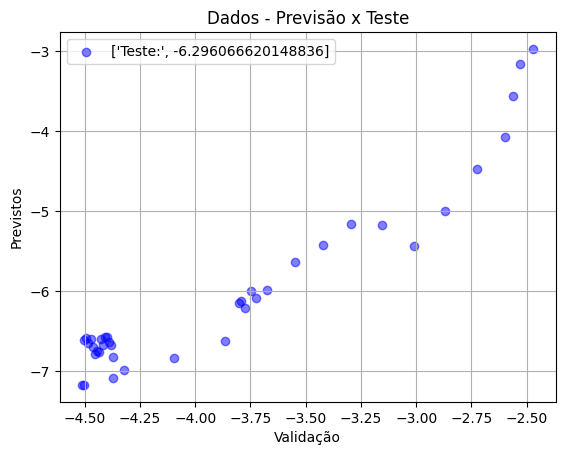

SMAPE: 43.11984871467661


In [374]:
#______________________Redes Neurais______________________________________

from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(verbose=False, max_iter=1000, tol=0.000001, solver='adam', shuffle=True, hidden_layer_sizes=(10), activation='identity')
regressor.fit(x_train_normalized, y_train_normalized)
score_train = regressor.score(x_train_normalized, y_train_normalized)
print('Score do Treinamento para Conjunto de Treinamento:', score_train)
#score_val = regressor.score(x_val_normalized, y_val_normalized)
#print('Score do Treinamento para Conjunto de Validação:', score_val)
previsoes = regressor.predict(x_test_normalized)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_test = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste:', score_test)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Validação")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_test_normalized))
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Teste:',score_test], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='blue', label= ['Teste',score_test], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

## Plota Gráficos de Dispersão

### Conjunto de Treinamento

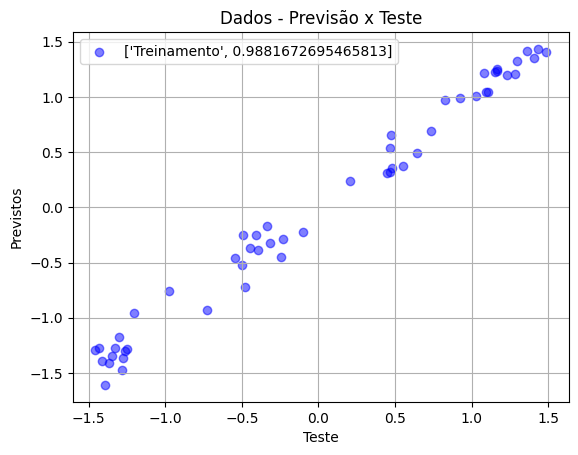

In [350]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_train = y_train_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_train_normalized))
qo_pred_train = saida.iloc[:,0]
ax.scatter(qo_train, qo_pred_train, color='blue', label= ['Treinamento',score_train], alpha=0.5)
#ax.scatter(y_train_normalized, regressor.predict(x_train_normalized), color='blue', label= ['Treinamento',score_train], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

### Conjunto de Teste

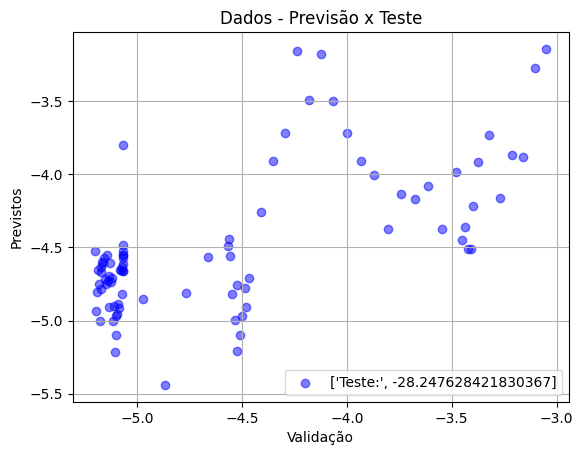

In [260]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Validação")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_test_normalized))
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Teste:',score_test], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='blue', label= ['Teste',score_test], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

# Modelo de Ridge Regression

Score da base de Treinamento para regressão linear:  0.99778638913472
Coeficientes da regressão linear multipla:  [[ 9.52084676e-02  7.96703111e-02 -5.28198824e-02  4.47008975e-02
  -5.49006336e-02  4.24333809e-02  5.61706455e-02 -1.87863465e-02
  -1.43551842e-03 -6.25485762e-02 -3.13113960e-03  2.94483081e-02
   2.36646968e-02 -2.52488828e-02 -1.33762533e-02 -1.49462104e-02
   8.83998368e-03  2.23286779e-02 -3.71771552e-02  1.10391564e-02
   3.45017520e-03 -1.82862306e-04 -1.05220809e-02 -1.75439124e-02
   3.43288062e-02  1.91376295e-02 -7.80160837e-05 -7.60941497e-03
   3.73862659e-02 -1.32691678e-02  1.97852200e-02 -2.27783774e-02
   3.09188528e-03  2.68407191e-02 -1.95046805e-02  2.94147416e-02
  -3.20930980e-02  1.17090516e-02  2.77873112e-04  3.67732830e-02
   9.67422039e-02  4.85802375e-02  1.36132600e-03 -2.66423878e-02
  -2.97296465e-04  2.54341517e-01  1.99053671e-01 -1.30593787e-01
  -5.14114759e-02 -1.55350427e-01]
 [ 5.97508864e-02  5.98139178e-02  1.25565573e-01  3.669233

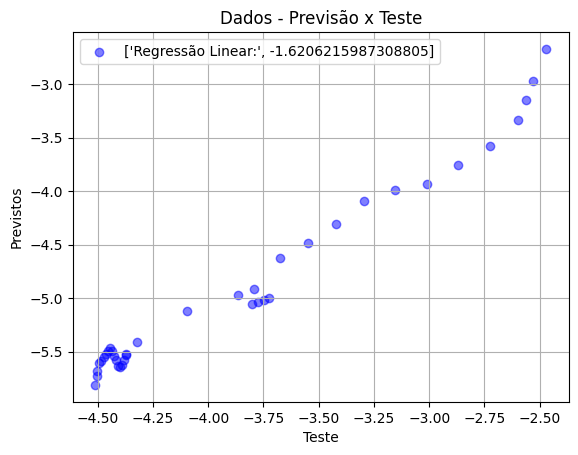

SMAPE: 23.301877200195495


In [385]:
#______________________Ridge Regression_______________________________________

from sklearn.linear_model import Ridge
regressor = Ridge(alpha=0.5, fit_intercept=True)
regressor.fit(x_train_normalized, y_train_normalized)
# Avaliação do treinamento
score = regressor.score(x_train_normalized, y_train_normalized)
#Return the coefficient of determination R^2 of the prediction.
print('Score da base de Treinamento para regressão linear: ', score)
previsoes = regressor.predict(x_test_normalized)
coeficientes = regressor.coef_
print("Coeficientes da regressão linear multipla: ",coeficientes)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_t = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste', score_t)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Regressão Linear:',score_t], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

# Modelo Lasso Linear Regression

Score da base de Treinamento para regressão linear:  0.9978505046960384
Coeficientes da regressão linear multipla:  [[ 0.06434331  0.         -0.          0.          0.00142016  0.
   0.         -0.          0.00290081 -0.          0.          0.
  -0.00412957  0.         -0.          0.          0.         -0.00202433
   0.         -0.          0.          0.         -0.          0.
   0.          0.          0.         -0.          0.          0.
   0.          0.         -0.         -0.          0.          0.
   0.          0.         -0.          0.          0.          0.
  -0.         -0.         -0.          0.92627018  0.         -0.
  -0.         -0.01377954]
 [ 0.          0.         -0.          0.         -0.          0.
   0.         -0.          0.0117412  -0.          0.00455736  0.
  -0.          0.         -0.00129433  0.01873107  0.         -0.
   0.         -0.          0.          0.         -0.          0.
  -0.          0.          0.         -0.          0.    

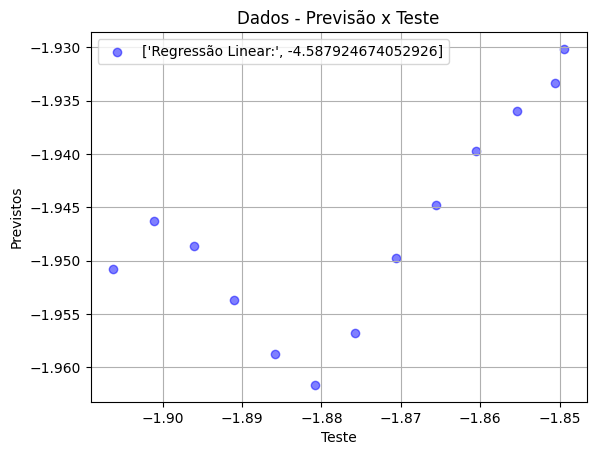

SMAPE: 0.037114241517549405


In [23]:
#______________________Regressão Linear Lasso_______________________________________

from sklearn import linear_model
regressor = linear_model.Lasso(alpha=0.003)
#from sklearn.linear_model import HuberRegressor, LinearRegression
#regressor = HuberRegressor()
regressor.fit(x_train_normalized, y_train_normalized)
# Avaliação do treinamento
score = regressor.score(x_train_normalized, y_train_normalized)
#Return the coefficient of determination R^2 of the prediction.
print('Score da base de Treinamento para regressão linear: ', score)
previsoes = regressor.predict(x_test_normalized)
coeficientes = regressor.coef_
print("Coeficientes da regressão linear multipla: ",coeficientes)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_t = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste', score_t)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Regressão Linear:',score_t], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

# Imagem coeficientes

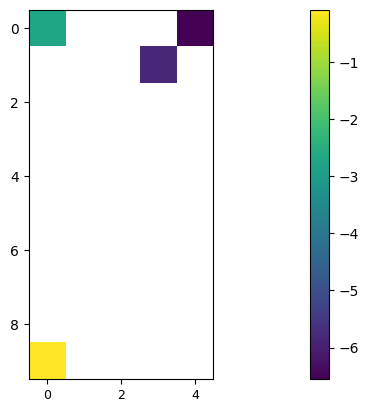

In [24]:
coef = coeficientes[0,:]
coef = np.reshape(coef, (10,5))

# Labels
#xlabs = ["P1Qo", "P2Qo", "P3Qo", "P4Qo", "P5Qo", "P6Qo",# "P1Qg", "P2Qg", "P3Qg", "P4Qg", "P5Qg", "P6Qg", #"P1Qw", "P2Qw", "P3Qw", "P4Qw", "P5Qw", "P6Qw",
#         "I1Qgi", "I3Qgi", "I6Qgi", "I7Qgi", "I2Qwi", "I4Qwi", "I5Qwi"]
#ylabs = ["t-10", "t-9", "t-8", "t-7", "t-6", "t-5", "t-4", "t-3", "t-2", "t-1"]

# Heat map
fig, ax = plt.subplots()
fig.set_figwidth(25)
im = ax.imshow(log(coef))

# Add the labels
#ax.set_xticks(np.arange(len(xlabs)), labels = xlabs)
#ax.set_yticks(np.arange(len(ylabs)), labels = ylabs)
plt.xticks(fontsize=9)
# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax, shrink = 1)
#cbar.ax.set_yticklabels(['', '', '']) 
#cbar.ax.set_ylabel("Color bar", rotation = -90, va = "bottom")

# Visualização dos Resultados na forma Temporal

###  Para passo a passo

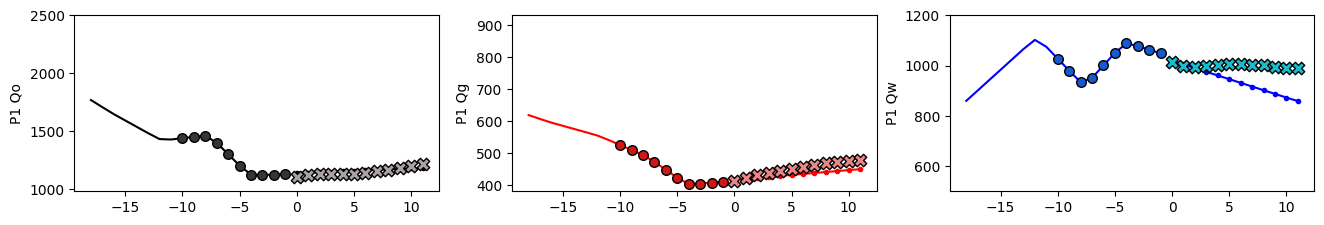

In [25]:
# Entradas de injeções futuras para serem concatenadas (necessário shift de 1 time step)
inj_schedule = x_test_normalized.values[1:,(len(x_test_normalized.columns)-2):] #últimas 12 colunas correspondem aos dados da injeção presente
# Pega apenas o primeiro time step das entradas de teste
in_timeseries = x_test_normalized[1:2].values

pred_look_forward = 12 #número de passos para repetir procedimento de previsão
y_predicted = []

for i in range(pred_look_forward):
  prev_atual = regressor.predict(in_timeseries)
  in_timeseries = np.concatenate((in_timeseries[:,Dataset_CAR_resample_cut.shape[1]:],prev_atual,inj_schedule[i:(i+1),:]),axis=1)
  y_predicted.extend(preprocessParams_y.inverse_transform(prev_atual))

y_pred_df = pd.DataFrame(y_predicted)

plt.figure(figsize=(16, 16))
plot_col = 1

for n_pocos in range(1,2):
#n_pocos = 3
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P{n_pocos} Qo')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_test_normalized.columns)+(n_pocos-1)*3)], zorder=0, color = 'k')
  plt.plot(y_pred_df.index, y_test[:pred_look_forward][(len(x_test_normalized.columns)+(n_pocos-1)*3)], marker='.', zorder=1, color = 'k')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_test_normalized.columns)+(n_pocos-1)*3)], marker='o', edgecolors='k', label='Predictions', c='#383434', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[((n_pocos-1)*3)], marker='X', edgecolors='k', label='Predictions', c='#aba2a2', s=80, zorder=3)
  plt.ylim(980, 2500)
  plot_col = plot_col +1
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P{n_pocos} Qg')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_test_normalized.columns)+(n_pocos-1)*3+1)], zorder=0, color = 'r')
  plt.plot(y_pred_df.index, y_test[:pred_look_forward][(len(x_test_normalized.columns)+(n_pocos-1)*3+1)], marker='.', zorder=1, color = 'r')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_test_normalized.columns)+(n_pocos-1)*3+1)], marker='o', edgecolors='k', label='Predictions', c='#cf1717', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[(n_pocos-1)*3+1], marker='X', edgecolors='k', label='Predictions', c='#eb8686', s=80, zorder=3)
  plt.ylim(380, 930)
  plot_col = plot_col +1
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P{n_pocos} Qw')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_test_normalized.columns)+(n_pocos-1)*3+2)], zorder=0, color = 'b')
  plt.plot(y_pred_df.index, y_test[:pred_look_forward][(len(x_test_normalized.columns)+(n_pocos-1)*3+2)], marker='.', zorder=1, color = 'b')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_test_normalized.columns)+(n_pocos-1)*3+2)], marker='o', edgecolors='k', label='Predictions', c='#175acf', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[(n_pocos-1)*3+2], marker='X', edgecolors='k', label='Predictions', c='#17becf', s=80, zorder=3)
  plt.ylim(500, 1200)
  plot_col = plot_col +1


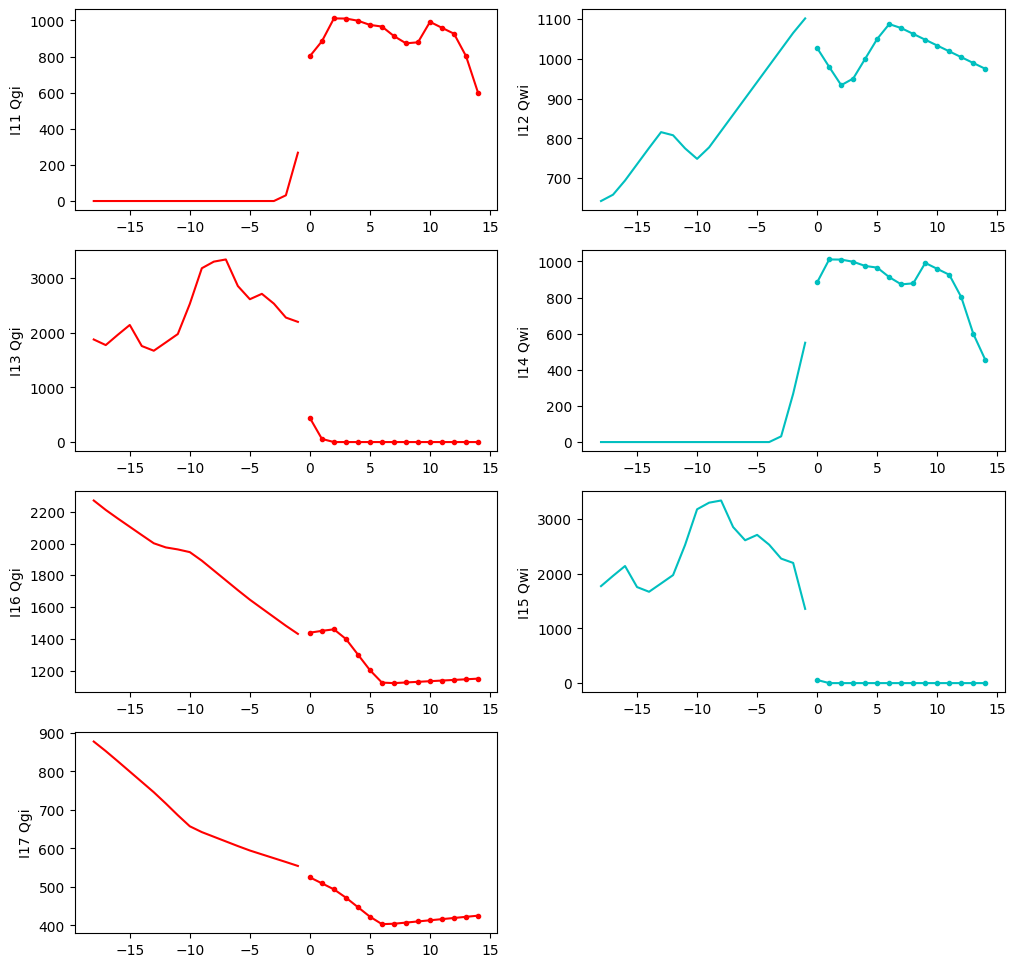

In [425]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
plt.ylabel('I11 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-7)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-7)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 2)
plt.ylabel('I12 Qwi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-3)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-3)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 3)
plt.ylabel('I13 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-6)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-6)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 4)
plt.ylabel('I14 Qwi')
plt.plot(range(-18, 0), x_train[(len(y_train)-18):][(len(x_test_normalized.columns)-2)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-2)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 5)
plt.ylabel('I16 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-5)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-5)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 6)
plt.ylabel('I15 Qwi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-1)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-1)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 7)
plt.ylabel('I17 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-4)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-4)], marker='.', zorder=1, color = 'red')